Files already downloaded and verified

Experiment: grid_encoder | encoder_type=grid
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt


current sampler is ODE sampler, but w_scheduler is enabled
/tmp/ipykernel_690265/1241671848.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path

Metrics: {'mse32_full': 0.059076763689517975, 'mse32_noncond': 0.07386398315429688, 'mse128_full': 0.048184867948293686, 'mse128_noncond': 0.060232002288103104}

Experiment: perceiver_encoder | encoder_type=perceiver
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_imagenet/checkpoints/last-v5.ckpt


current sampler is ODE sampler, but w_scheduler is enabled


Metrics: {'mse32_full': 0.031437456607818604, 'mse32_noncond': 0.03930641710758209, 'mse128_full': 0.1819278448820114, 'mse128_noncond': 0.22741326689720154}


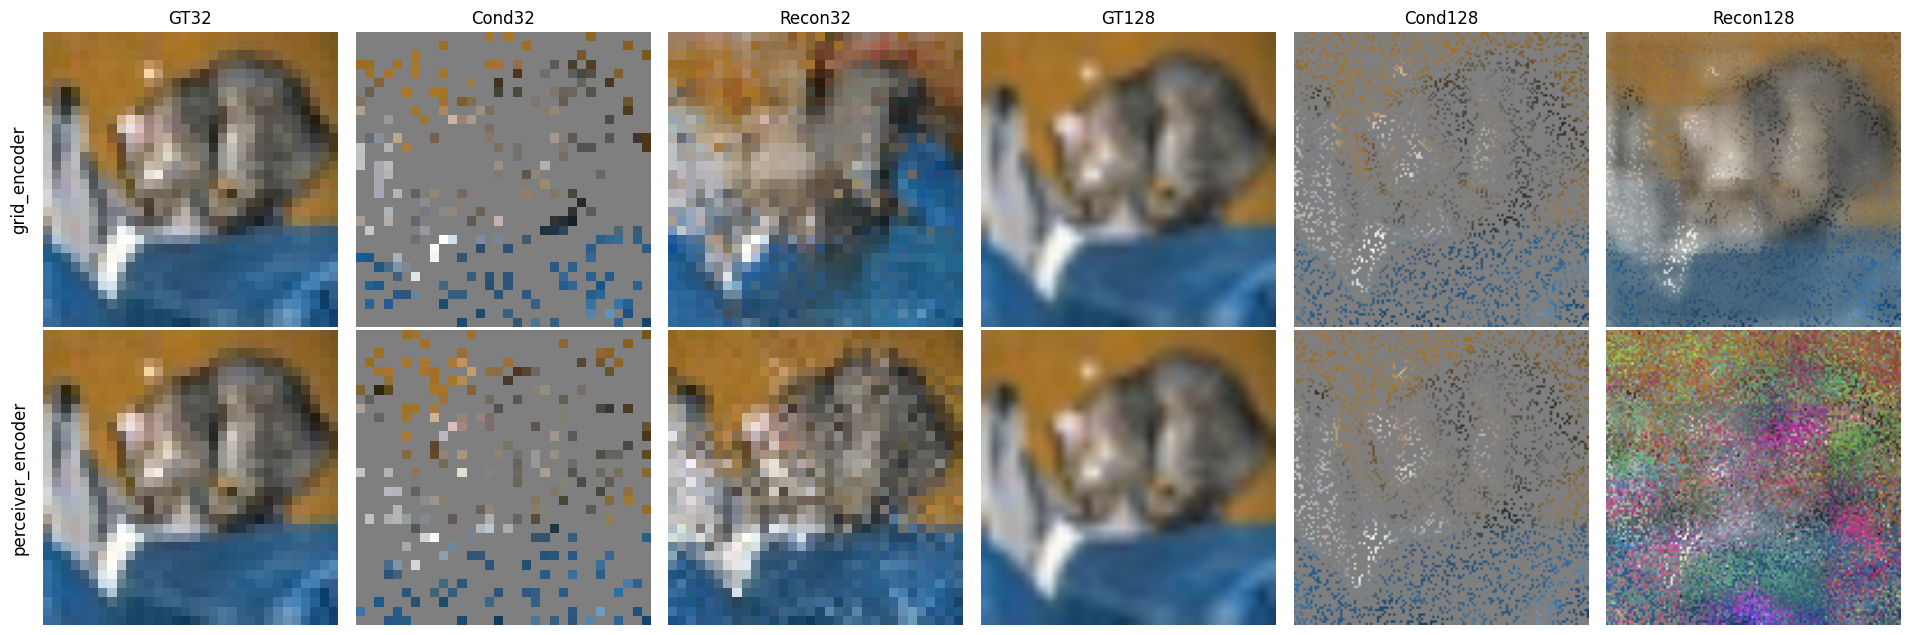

In [6]:
# === Sparse recon + super-res eval for PixNerDiT (grid vs perceiver encoders) ===
import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# -----------------------
# 0) Make sure we're in the PixNerd repo root (so `import src...` works)
# -----------------------
if not (Path.cwd() / "src").exists():
    # common: notebook is in parent dir
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

# Disable torch.compile/dynamo issues (matches your training script style)
torch._dynamo.config.disable = True

# -----------------------
# 1) Imports from your codebase
# -----------------------
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# -----------------------
# 2) Configure what to compare
#    - Use separate ckpts if you actually trained separate models.
#    - If you try to load a "grid" ckpt into a "perceiver" model, strict=False will skip mismatched weights.
# -----------------------
EXPERIMENTS = [
    dict(
        name="grid_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt",
        encoder_type="grid",          # "grid" or "perceiver"
        # match training hyperparams:
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        # sparsity behavior:
        sparsity=0.4,
        cond_fraction=0.5,
    ),
    dict(
        name="perceiver_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_imagenet/checkpoints/last-v5.ckpt",
        encoder_type="perceiver",
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        sparsity=0.4,
        cond_fraction=0.5,
        # perceiver-specific knobs (only used if your PixNerDiT exposes them in __init__)
        # max_points=4096,
        # perceiver_num_latents=256,
        # perceiver_cross_heads=1,
    ),
]

# -----------------------
# 3) Helpers
# -----------------------
def build_lightning_model(cfg):
    main_scheduler = LinearScheduler()

    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=cfg["num_classes"])

    # Build denoiser
    denoiser_kwargs = dict(
        in_channels=3,
        patch_size=cfg["patch_size"],
        num_groups=cfg["num_groups"],
        hidden_size=cfg["hidden_size"],
        decoder_hidden_size=cfg["decoder_hidden_size"],
        num_encoder_blocks=cfg["num_encoder_blocks"],
        num_decoder_blocks=cfg["num_decoder_blocks"],
        num_classes=cfg["num_classes"],
    )
    # If your PixNerDiT has encoder_type in its signature, pass it:
    if "encoder_type" in cfg:
        denoiser_kwargs["encoder_type"] = cfg["encoder_type"]

    # Optional perceiver knobs if present in your model signature
    for k in ["max_points", "perceiver_num_latents", "perceiver_cross_heads"]:
        if k in cfg:
            denoiser_kwargs[k] = cfg[k]

    denoiser = PixNerDiT(**denoiser_kwargs)

    sampler = EulerSampler(
        num_steps=50,                 # you can change
        guidance=2.0,                 # you can change
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
    )

    trainer = FlowMatchingTrainer(
        scheduler=main_scheduler,
        lognorm_t=True,
        timeshift=1.0,
    )

    ema_tracker = SimpleEMA(decay=0.9999)

    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=cfg["sparsity"],
        cond_fraction=cfg["cond_fraction"],
    )
    return model


def load_ckpt_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    model = model.to(device)
    model.eval()
    # keep inference stable
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    return missing, unexpected


@torch.no_grad()
def run_sparse_recon(model, images, labels, superres_scale=4):
    """
    images: (B,3,32,32) in [-1,1]
    returns recon32, recon128 and metrics
    """
    device = images.device
    B = images.shape[0]

    # --- 32x32 recon ---
    x_latent_32 = model.vae.encode(images)  # (B,3,32,32) for PixelAE
    cond_mask_32, target_mask_32 = model._make_sparsity_masks(x_latent_32)

    condition, uncondition = model.conditioner(labels)

    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_32,
        condition,
        uncondition,
        cond_mask=cond_mask_32,
        x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    # MSE full + MSE on non-conditioning pixels
    mse32_full = F.mse_loss(recon_32, images).item()
    inv_mask32 = (1.0 - cond_mask_32).expand_as(images)
    mse32_noncond = ((recon_32 - images) ** 2 * inv_mask32).sum() / (inv_mask32.sum() + 1e-8)
    mse32_noncond = mse32_noncond.item()

    # Conditioning visualization (grey=0 in [-1,1])
    cond_vis_32 = cond_mask_32.expand_as(images) * images

    # --- 128x128 "super-res" recon (for CIFAR this is upsampled GT) ---
    H_hr = images.shape[-2] * superres_scale
    W_hr = images.shape[-1] * superres_scale
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)

    x_latent_128 = model.vae.encode(images_hr)
    cond_mask_128, target_mask_128 = model._make_sparsity_masks(x_latent_128)

    # temporarily set decoder scaling on BOTH nets
    old = (getattr(model.denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.denoiser, "decoder_patch_scaling_w", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_w", 1.0))
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h = superres_scale
        model.denoiser.decoder_patch_scaling_w = superres_scale
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h = superres_scale
        model.ema_denoiser.decoder_patch_scaling_w = superres_scale

    noise_128 = torch.randn_like(x_latent_128)
    samples_latent_128 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_128,
        condition,
        uncondition,
        cond_mask=cond_mask_128,
        x_cond=x_latent_128,
    )
    recon_128 = model.vae.decode(samples_latent_128)

    # restore scaling
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h, model.denoiser.decoder_patch_scaling_w = old[0], old[1]
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h, model.ema_denoiser.decoder_patch_scaling_w = old[2], old[3]

    mse128_full = F.mse_loss(recon_128, images_hr).item()
    inv_mask128 = (1.0 - cond_mask_128).expand_as(images_hr)
    mse128_noncond = ((recon_128 - images_hr) ** 2 * inv_mask128).sum() / (inv_mask128.sum() + 1e-8)
    mse128_noncond = mse128_noncond.item()

    cond_vis_128 = cond_mask_128.expand_as(images_hr) * images_hr

    metrics = dict(
        mse32_full=mse32_full,
        mse32_noncond=mse32_noncond,
        mse128_full=mse128_full,
        mse128_noncond=mse128_noncond,
    )
    return recon_32, cond_vis_32, recon_128, cond_vis_128, images_hr, metrics


def to_img01(x):
    # x: [-1,1] -> [0,1]
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# -----------------------
# 4) Load a fixed CIFAR-10 batch
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # -> [-1,1]
])

ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# -----------------------
# 5) Run each experiment and plot
# -----------------------
all_results = []

for cfg in EXPERIMENTS:
    print("\n" + "="*80)
    print(f"Experiment: {cfg['name']} | encoder_type={cfg.get('encoder_type','(default)')}")
    print(f"ckpt: {cfg['ckpt_path']}")

    model = build_lightning_model(cfg)
    missing, unexpected = load_ckpt_into_model(model, cfg["ckpt_path"], device=device)

    if len(missing) or len(unexpected):
        print(f"[load_state_dict strict=False] missing={len(missing)} unexpected={len(unexpected)}")
        # uncomment if you want details:
        # print("missing:", missing[:20])
        # print("unexpected:", unexpected[:20])

    recon32, cond32, recon128, cond128, gt128, metrics = run_sparse_recon(
        model, images, labels, superres_scale=4
    )

    print("Metrics:", metrics)

    all_results.append((cfg["name"], metrics, recon32, cond32, recon128, cond128, gt128))

# Plot: rows = experiments, cols = GT32 | Cond32 | Recon32 | GT128 | Cond128 | Recon128
cols = ["GT32", "Cond32", "Recon32", "GT128", "Cond128", "Recon128"]
rows = len(all_results)
plt.figure(figsize=(3.2*len(cols), 3.2*rows))

for r, (name, metrics, recon32, cond32, recon128, cond128, gt128) in enumerate(all_results):
    gt32 = images
    for c, (title, tensor) in enumerate([
        ("GT32", gt32),
        ("Cond32", cond32),
        ("Recon32", recon32),
        ("GT128", gt128),
        ("Cond128", cond128),
        ("Recon128", recon128),
    ]):
        ax = plt.subplot(rows, len(cols), r*len(cols) + c + 1)
        # show first image of the batch
        ax.imshow(to_img01(tensor[0]).permute(1,2,0))
        ax.axis("off")
        if r == 0:
            ax.set_title(title)
        if c == 0:
            ax.text(-0.05, 0.5, name, transform=ax.transAxes, rotation=90,
                    va="center", ha="right", fontsize=12)

plt.tight_layout()
plt.show()


Files already downloaded and verified

Experiment: grid_encoder | encoder_type=grid
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt


current sampler is ODE sampler, but w_scheduler is enabled
/tmp/ipykernel_1628591/207358888.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path

[load_state_dict strict=False] missing=2 unexpected=0
Metrics: {'mse32_full': 0.059076763689517975, 'mse32_noncond': 0.07386398315429688, 'mse128_full': 0.048184867948293686, 'mse128_noncond': 0.060232002288103104}

Experiment: perceiver_encoder | encoder_type=perceiver
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last-v1.ckpt


current sampler is ODE sampler, but w_scheduler is enabled


Metrics: {'mse32_full': 0.03300236165523529, 'mse32_noncond': 0.041263025254011154, 'mse128_full': 0.11452709138393402, 'mse128_noncond': 0.14316104352474213}


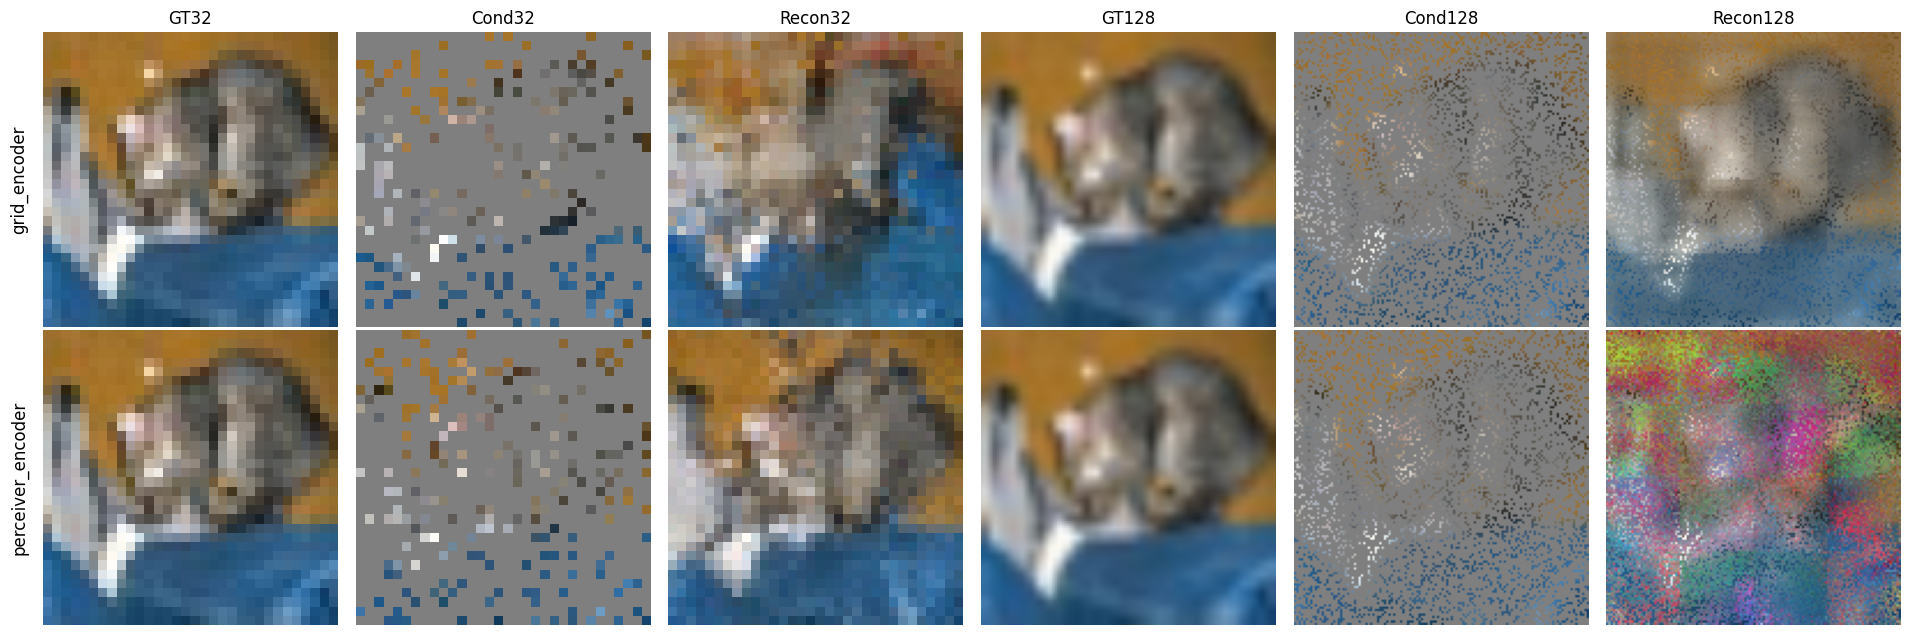

In [2]:
# === Sparse recon + super-res eval for PixNerDiT (grid vs perceiver encoders) ===
import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# -----------------------
# 0) Make sure we're in the PixNerd repo root (so `import src...` works)
# -----------------------
if not (Path.cwd() / "src").exists():
    # common: notebook is in parent dir
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

# Disable torch.compile/dynamo issues (matches your training script style)
torch._dynamo.config.disable = True

# -----------------------
# 1) Imports from your codebase
# -----------------------
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# -----------------------
# 2) Configure what to compare
#    - Use separate ckpts if you actually trained separate models.
#    - If you try to load a "grid" ckpt into a "perceiver" model, strict=False will skip mismatched weights.
# -----------------------
EXPERIMENTS = [
    dict(
        name="grid_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt",
        encoder_type="grid",          # "grid" or "perceiver"
        # match training hyperparams:
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        # sparsity behavior:
        sparsity=0.4,
        cond_fraction=0.5,
    ),
    dict(
        name="perceiver_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last-v1.ckpt",
        encoder_type="perceiver",
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        sparsity=0.4,
        cond_fraction=0.5,
        # perceiver-specific knobs (only used if your PixNerDiT exposes them in __init__)
        # max_points=4096,
        # perceiver_num_latents=256,
        # perceiver_cross_heads=1,
    ),
]

# -----------------------
# 3) Helpers
# -----------------------
def build_lightning_model(cfg):
    main_scheduler = LinearScheduler()

    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=cfg["num_classes"])

    # Build denoiser
    denoiser_kwargs = dict(
        in_channels=3,
        patch_size=cfg["patch_size"],
        num_groups=cfg["num_groups"],
        hidden_size=cfg["hidden_size"],
        decoder_hidden_size=cfg["decoder_hidden_size"],
        num_encoder_blocks=cfg["num_encoder_blocks"],
        num_decoder_blocks=cfg["num_decoder_blocks"],
        num_classes=cfg["num_classes"],
    )
    # If your PixNerDiT has encoder_type in its signature, pass it:
    if "encoder_type" in cfg:
        denoiser_kwargs["encoder_type"] = cfg["encoder_type"]

    # Optional perceiver knobs if present in your model signature
    for k in ["max_points", "perceiver_num_latents", "perceiver_cross_heads"]:
        if k in cfg:
            denoiser_kwargs[k] = cfg[k]

    denoiser = PixNerDiT(**denoiser_kwargs)

    sampler = EulerSampler(
        num_steps=50,                 # you can change
        guidance=2.0,                 # you can change
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
    )

    trainer = FlowMatchingTrainer(
        scheduler=main_scheduler,
        lognorm_t=True,
        timeshift=1.0,
    )

    ema_tracker = SimpleEMA(decay=0.9999)

    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=cfg["sparsity"],
        cond_fraction=cfg["cond_fraction"],
    )
    return model


def load_ckpt_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    model = model.to(device)
    model.eval()
    # keep inference stable
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    return missing, unexpected


@torch.no_grad()
def run_sparse_recon(model, images, labels, superres_scale=4):
    """
    images: (B,3,32,32) in [-1,1]
    returns recon32, recon128 and metrics
    """
    device = images.device
    B = images.shape[0]

    # --- 32x32 recon ---
    x_latent_32 = model.vae.encode(images)  # (B,3,32,32) for PixelAE
    cond_mask_32, target_mask_32 = model._make_sparsity_masks(x_latent_32)

    condition, uncondition = model.conditioner(labels)

    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_32,
        condition,
        uncondition,
        cond_mask=cond_mask_32,
        x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    # MSE full + MSE on non-conditioning pixels
    mse32_full = F.mse_loss(recon_32, images).item()
    inv_mask32 = (1.0 - cond_mask_32).expand_as(images)
    mse32_noncond = ((recon_32 - images) ** 2 * inv_mask32).sum() / (inv_mask32.sum() + 1e-8)
    mse32_noncond = mse32_noncond.item()

    # Conditioning visualization (grey=0 in [-1,1])
    cond_vis_32 = cond_mask_32.expand_as(images) * images

    # --- 128x128 "super-res" recon (for CIFAR this is upsampled GT) ---
    H_hr = images.shape[-2] * superres_scale
    W_hr = images.shape[-1] * superres_scale
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)

    x_latent_128 = model.vae.encode(images_hr)
    cond_mask_128, target_mask_128 = model._make_sparsity_masks(x_latent_128)

    # temporarily set decoder scaling on BOTH nets
    old = (getattr(model.denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.denoiser, "decoder_patch_scaling_w", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_w", 1.0))
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h = superres_scale
        model.denoiser.decoder_patch_scaling_w = superres_scale
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h = superres_scale
        model.ema_denoiser.decoder_patch_scaling_w = superres_scale

    noise_128 = torch.randn_like(x_latent_128)
    samples_latent_128 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_128,
        condition,
        uncondition,
        cond_mask=cond_mask_128,
        x_cond=x_latent_128,
    )
    recon_128 = model.vae.decode(samples_latent_128)

    # restore scaling
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h, model.denoiser.decoder_patch_scaling_w = old[0], old[1]
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h, model.ema_denoiser.decoder_patch_scaling_w = old[2], old[3]

    mse128_full = F.mse_loss(recon_128, images_hr).item()
    inv_mask128 = (1.0 - cond_mask_128).expand_as(images_hr)
    mse128_noncond = ((recon_128 - images_hr) ** 2 * inv_mask128).sum() / (inv_mask128.sum() + 1e-8)
    mse128_noncond = mse128_noncond.item()

    cond_vis_128 = cond_mask_128.expand_as(images_hr) * images_hr

    metrics = dict(
        mse32_full=mse32_full,
        mse32_noncond=mse32_noncond,
        mse128_full=mse128_full,
        mse128_noncond=mse128_noncond,
    )
    return recon_32, cond_vis_32, recon_128, cond_vis_128, images_hr, metrics


def to_img01(x):
    # x: [-1,1] -> [0,1]
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# -----------------------
# 4) Load a fixed CIFAR-10 batch
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # -> [-1,1]
])

ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# -----------------------
# 5) Run each experiment and plot
# -----------------------
all_results = []

for cfg in EXPERIMENTS:
    print("\n" + "="*80)
    print(f"Experiment: {cfg['name']} | encoder_type={cfg.get('encoder_type','(default)')}")
    print(f"ckpt: {cfg['ckpt_path']}")

    model = build_lightning_model(cfg)
    missing, unexpected = load_ckpt_into_model(model, cfg["ckpt_path"], device=device)

    if len(missing) or len(unexpected):
        print(f"[load_state_dict strict=False] missing={len(missing)} unexpected={len(unexpected)}")
        # uncomment if you want details:
        # print("missing:", missing[:20])
        # print("unexpected:", unexpected[:20])

    recon32, cond32, recon128, cond128, gt128, metrics = run_sparse_recon(
        model, images, labels, superres_scale=4
    )

    print("Metrics:", metrics)

    all_results.append((cfg["name"], metrics, recon32, cond32, recon128, cond128, gt128))

# Plot: rows = experiments, cols = GT32 | Cond32 | Recon32 | GT128 | Cond128 | Recon128
cols = ["GT32", "Cond32", "Recon32", "GT128", "Cond128", "Recon128"]
rows = len(all_results)
plt.figure(figsize=(3.2*len(cols), 3.2*rows))

for r, (name, metrics, recon32, cond32, recon128, cond128, gt128) in enumerate(all_results):
    gt32 = images
    for c, (title, tensor) in enumerate([
        ("GT32", gt32),
        ("Cond32", cond32),
        ("Recon32", recon32),
        ("GT128", gt128),
        ("Cond128", cond128),
        ("Recon128", recon128),
    ]):
        ax = plt.subplot(rows, len(cols), r*len(cols) + c + 1)
        # show first image of the batch
        ax.imshow(to_img01(tensor[0]).permute(1,2,0))
        ax.axis("off")
        if r == 0:
            ax.set_title(title)
        if c == 0:
            ax.text(-0.05, 0.5, name, transform=ax.transAxes, rotation=90,
                    va="center", ha="right", fontsize=12)

plt.tight_layout()
plt.show()


Files already downloaded and verified

Experiment: grid_encoder | encoder_type=grid
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt


current sampler is ODE sampler, but w_scheduler is enabled
/tmp/ipykernel_1628591/207358888.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path

[load_state_dict strict=False] missing=2 unexpected=0
Metrics: {'mse32_full': 0.059076763689517975, 'mse32_noncond': 0.07386398315429688, 'mse128_full': 0.048184867948293686, 'mse128_noncond': 0.060232002288103104}

Experiment: perceiver_encoder | encoder_type=perceiver
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last-v1.ckpt


current sampler is ODE sampler, but w_scheduler is enabled


Metrics: {'mse32_full': 0.03136628866195679, 'mse32_noncond': 0.03921743482351303, 'mse128_full': 0.11303751170635223, 'mse128_noncond': 0.1412990391254425}


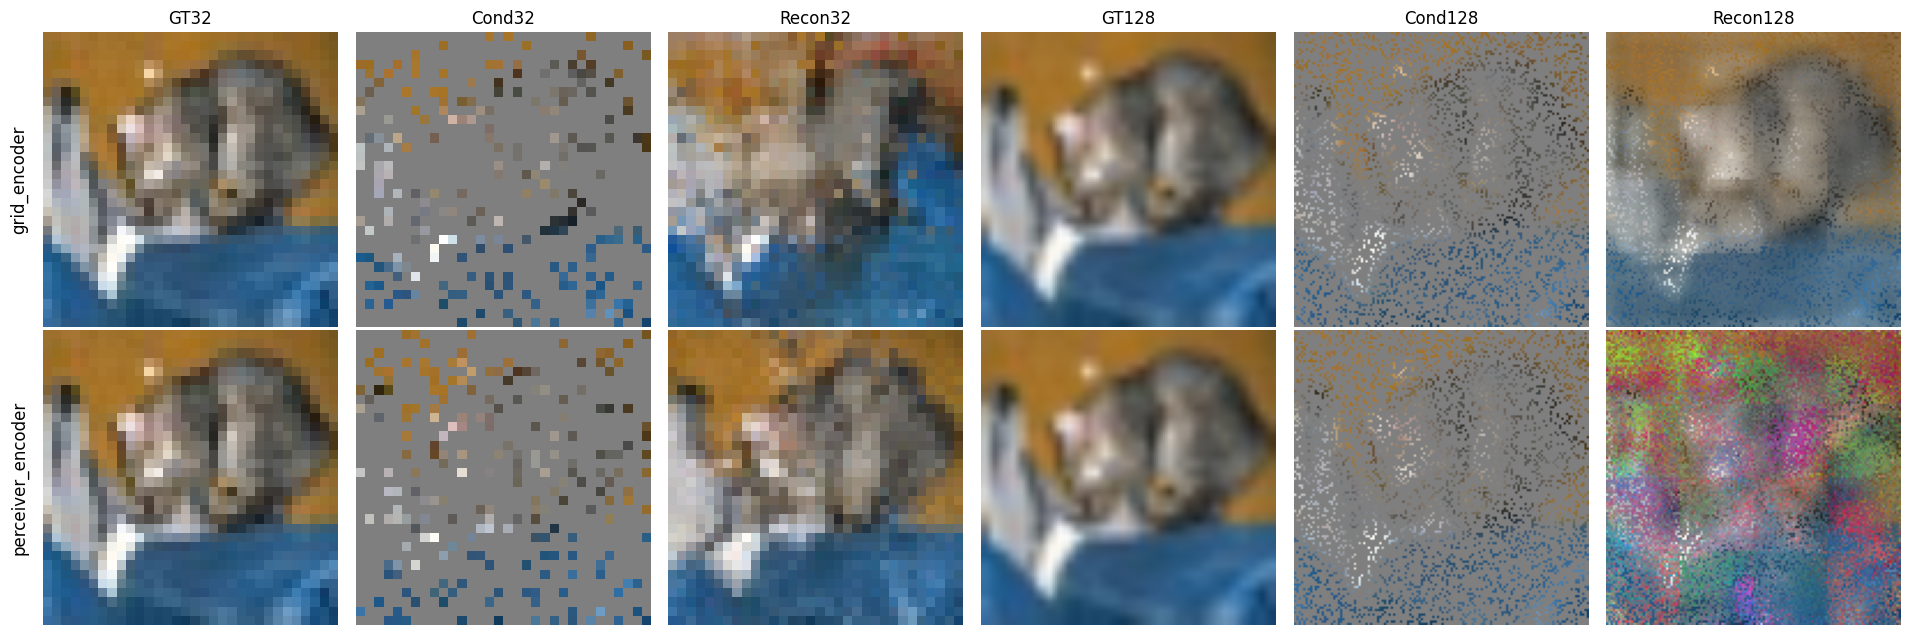

In [4]:
# === Sparse recon + super-res eval for PixNerDiT (grid vs perceiver encoders) ===
import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# -----------------------
# 0) Make sure we're in the PixNerd repo root (so `import src...` works)
# -----------------------
if not (Path.cwd() / "src").exists():
    # common: notebook is in parent dir
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

# Disable torch.compile/dynamo issues (matches your training script style)
torch._dynamo.config.disable = True

# -----------------------
# 1) Imports from your codebase
# -----------------------
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# -----------------------
# 2) Configure what to compare
#    - Use separate ckpts if you actually trained separate models.
#    - If you try to load a "grid" ckpt into a "perceiver" model, strict=False will skip mismatched weights.
# -----------------------
EXPERIMENTS = [
    dict(
        name="grid_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt",
        encoder_type="grid",          # "grid" or "perceiver"
        # match training hyperparams:
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        # sparsity behavior:
        sparsity=0.4,
        cond_fraction=0.5,
    ),
    dict(
        name="perceiver_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last-v1.ckpt",
        encoder_type="perceiver",
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        sparsity=0.4,
        cond_fraction=0.5,
        # perceiver-specific knobs (only used if your PixNerDiT exposes them in __init__)
        # max_points=4096,
        # perceiver_num_latents=256,
        # perceiver_cross_heads=1,
    ),
]

# -----------------------
# 3) Helpers
# -----------------------
def build_lightning_model(cfg):
    main_scheduler = LinearScheduler()

    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=cfg["num_classes"])

    # Build denoiser
    denoiser_kwargs = dict(
        in_channels=3,
        patch_size=cfg["patch_size"],
        num_groups=cfg["num_groups"],
        hidden_size=cfg["hidden_size"],
        decoder_hidden_size=cfg["decoder_hidden_size"],
        num_encoder_blocks=cfg["num_encoder_blocks"],
        num_decoder_blocks=cfg["num_decoder_blocks"],
        num_classes=cfg["num_classes"],
    )
    # If your PixNerDiT has encoder_type in its signature, pass it:
    if "encoder_type" in cfg:
        denoiser_kwargs["encoder_type"] = cfg["encoder_type"]

    # Optional perceiver knobs if present in your model signature
    for k in ["max_points", "perceiver_num_latents", "perceiver_cross_heads"]:
        if k in cfg:
            denoiser_kwargs[k] = cfg[k]

    denoiser = PixNerDiT(**denoiser_kwargs)

    sampler = EulerSampler(
        num_steps=50,                 # you can change
        guidance=2.0,                 # you can change
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
    )

    trainer = FlowMatchingTrainer(
        scheduler=main_scheduler,
        lognorm_t=True,
        timeshift=1.0,
    )

    ema_tracker = SimpleEMA(decay=0.9999)

    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=cfg["sparsity"],
        cond_fraction=cfg["cond_fraction"],
    )
    return model


def load_ckpt_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    model = model.to(device)
    model.eval()
    # keep inference stable
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    return missing, unexpected


@torch.no_grad()
def run_sparse_recon(model, images, labels, superres_scale=4):
    """
    images: (B,3,32,32) in [-1,1]
    returns recon32, recon128 and metrics
    """
    device = images.device
    B = images.shape[0]

    # --- 32x32 recon ---
    x_latent_32 = model.vae.encode(images)  # (B,3,32,32) for PixelAE
    cond_mask_32, target_mask_32 = model._make_sparsity_masks(x_latent_32)

    condition, uncondition = model.conditioner(labels)

    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_32,
        condition,
        uncondition,
        cond_mask=cond_mask_32,
        x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    # MSE full + MSE on non-conditioning pixels
    mse32_full = F.mse_loss(recon_32, images).item()
    inv_mask32 = (1.0 - cond_mask_32).expand_as(images)
    mse32_noncond = ((recon_32 - images) ** 2 * inv_mask32).sum() / (inv_mask32.sum() + 1e-8)
    mse32_noncond = mse32_noncond.item()

    # Conditioning visualization (grey=0 in [-1,1])
    cond_vis_32 = cond_mask_32.expand_as(images) * images

    # --- 128x128 "super-res" recon (for CIFAR this is upsampled GT) ---
    H_hr = images.shape[-2] * superres_scale
    W_hr = images.shape[-1] * superres_scale
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)

    x_latent_128 = model.vae.encode(images_hr)
    cond_mask_128, target_mask_128 = model._make_sparsity_masks(x_latent_128)

    # temporarily set decoder scaling on BOTH nets
    old = (getattr(model.denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.denoiser, "decoder_patch_scaling_w", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_w", 1.0))
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h = superres_scale
        model.denoiser.decoder_patch_scaling_w = superres_scale
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h = superres_scale
        model.ema_denoiser.decoder_patch_scaling_w = superres_scale

    noise_128 = torch.randn_like(x_latent_128)
    samples_latent_128 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_128,
        condition,
        uncondition,
        cond_mask=cond_mask_128,
        x_cond=x_latent_128,
    )
    recon_128 = model.vae.decode(samples_latent_128)

    # restore scaling
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h, model.denoiser.decoder_patch_scaling_w = old[0], old[1]
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h, model.ema_denoiser.decoder_patch_scaling_w = old[2], old[3]

    mse128_full = F.mse_loss(recon_128, images_hr).item()
    inv_mask128 = (1.0 - cond_mask_128).expand_as(images_hr)
    mse128_noncond = ((recon_128 - images_hr) ** 2 * inv_mask128).sum() / (inv_mask128.sum() + 1e-8)
    mse128_noncond = mse128_noncond.item()

    cond_vis_128 = cond_mask_128.expand_as(images_hr) * images_hr

    metrics = dict(
        mse32_full=mse32_full,
        mse32_noncond=mse32_noncond,
        mse128_full=mse128_full,
        mse128_noncond=mse128_noncond,
    )
    return recon_32, cond_vis_32, recon_128, cond_vis_128, images_hr, metrics


def to_img01(x):
    # x: [-1,1] -> [0,1]
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# -----------------------
# 4) Load a fixed CIFAR-10 batch
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # -> [-1,1]
])

ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# -----------------------
# 5) Run each experiment and plot
# -----------------------
all_results = []

for cfg in EXPERIMENTS:
    print("\n" + "="*80)
    print(f"Experiment: {cfg['name']} | encoder_type={cfg.get('encoder_type','(default)')}")
    print(f"ckpt: {cfg['ckpt_path']}")

    model = build_lightning_model(cfg)
    missing, unexpected = load_ckpt_into_model(model, cfg["ckpt_path"], device=device)

    if len(missing) or len(unexpected):
        print(f"[load_state_dict strict=False] missing={len(missing)} unexpected={len(unexpected)}")
        # uncomment if you want details:
        # print("missing:", missing[:20])
        # print("unexpected:", unexpected[:20])

    recon32, cond32, recon128, cond128, gt128, metrics = run_sparse_recon(
        model, images, labels, superres_scale=4
    )

    print("Metrics:", metrics)

    all_results.append((cfg["name"], metrics, recon32, cond32, recon128, cond128, gt128))

# Plot: rows = experiments, cols = GT32 | Cond32 | Recon32 | GT128 | Cond128 | Recon128
cols = ["GT32", "Cond32", "Recon32", "GT128", "Cond128", "Recon128"]
rows = len(all_results)
plt.figure(figsize=(3.2*len(cols), 3.2*rows))

for r, (name, metrics, recon32, cond32, recon128, cond128, gt128) in enumerate(all_results):
    gt32 = images
    for c, (title, tensor) in enumerate([
        ("GT32", gt32),
        ("Cond32", cond32),
        ("Recon32", recon32),
        ("GT128", gt128),
        ("Cond128", cond128),
        ("Recon128", recon128),
    ]):
        ax = plt.subplot(rows, len(cols), r*len(cols) + c + 1)
        # show first image of the batch
        ax.imshow(to_img01(tensor[0]).permute(1,2,0))
        ax.axis("off")
        if r == 0:
            ax.set_title(title)
        if c == 0:
            ax.text(-0.05, 0.5, name, transform=ax.transAxes, rotation=90,
                    va="center", ha="right", fontsize=12)

plt.tight_layout()
plt.show()


/pscratch/sd/k/kevinval/envs/pixnerd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified

Experiment: perceiver_encoder | encoder_type=perceiver
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_perceiver/checkpoints/last-v1.ckpt


current sampler is ODE sampler, but w_scheduler is enabled
/tmp/ipykernel_1368375/521795881.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path

Metrics: {'mse32_full': 0.03705799579620361, 'mse32_noncond': 0.046333808451890945, 'mse128_full': 0.03286422789096832, 'mse128_noncond': 0.03316926956176758}


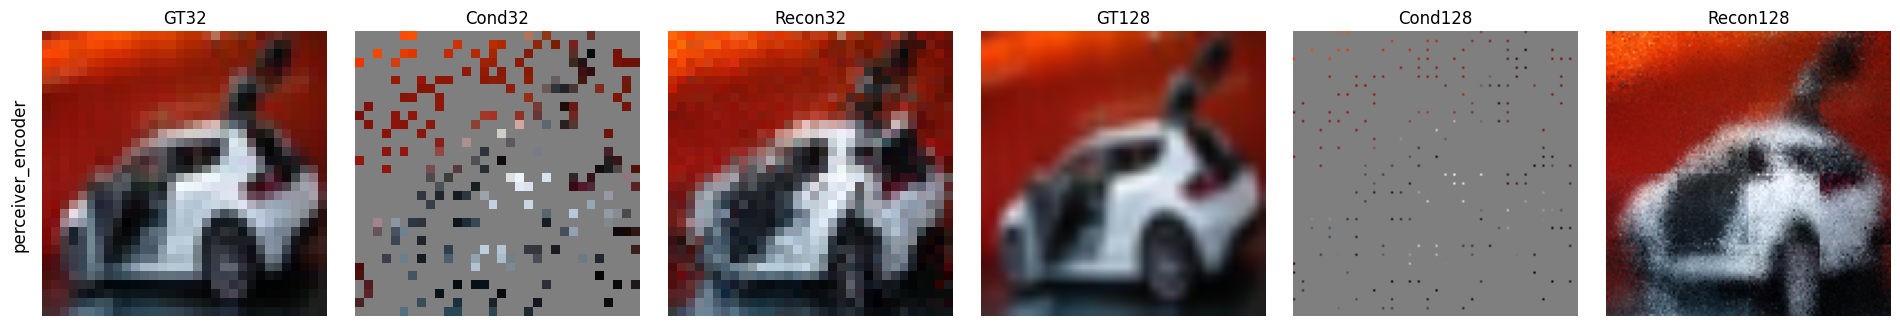

In [1]:
# === Sparse recon + super-res eval for PixNerDiT (grid vs perceiver encoders) ===
import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# -----------------------
# 0) Make sure we're in the PixNerd repo root (so `import src...` works)
# -----------------------
if not (Path.cwd() / "src").exists():
    # common: notebook is in parent dir
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

# Disable torch.compile/dynamo issues (matches your training script style)
torch._dynamo.config.disable = True

# -----------------------
# 1) Imports from your codebase
# -----------------------
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# -----------------------
# 2) Configure what to compare
#    - Use separate ckpts if you actually trained separate models.
#    - If you try to load a "grid" ckpt into a "perceiver" model, strict=False will skip mismatched weights.
# -----------------------
EXPERIMENTS = [
    # dict(
    #     name="grid_encoder",
    #     ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt",
    #     encoder_type="grid",          # "grid" or "perceiver"
    #     # match training hyperparams:
    #     hidden_size=512,
    #     decoder_hidden_size=64,
    #     num_encoder_blocks=8,
    #     num_decoder_blocks=2,
    #     patch_size=8,
    #     num_groups=8,
    #     num_classes=10,
    #     # sparsity behavior:
    #     sparsity=0.4,
    #     cond_fraction=0.5,
    # ),
    dict(
        name="perceiver_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_perceiver/checkpoints/last-v1.ckpt",
        encoder_type="perceiver",
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        sparsity=0.4,
        cond_fraction=0.5,
        # perceiver-specific knobs (only used if your PixNerDiT exposes them in __init__)
        # max_points=4096,
        # perceiver_num_latents=256,
        # perceiver_cross_heads=1,
    ),
]

# -----------------------
# 3) Helpers
# -----------------------
def build_lightning_model(cfg):
    main_scheduler = LinearScheduler()

    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=cfg["num_classes"])

    # Build denoiser
    denoiser_kwargs = dict(
        in_channels=3,
        patch_size=cfg["patch_size"],
        num_groups=cfg["num_groups"],
        hidden_size=cfg["hidden_size"],
        decoder_hidden_size=cfg["decoder_hidden_size"],
        num_encoder_blocks=cfg["num_encoder_blocks"],
        num_decoder_blocks=cfg["num_decoder_blocks"],
        num_classes=cfg["num_classes"],
    )
    # If your PixNerDiT has encoder_type in its signature, pass it:
    if "encoder_type" in cfg:
        denoiser_kwargs["encoder_type"] = cfg["encoder_type"]

    # Optional perceiver knobs if present in your model signature
    for k in ["max_points", "perceiver_num_latents", "perceiver_cross_heads"]:
        if k in cfg:
            denoiser_kwargs[k] = cfg[k]

    denoiser = PixNerDiT(**denoiser_kwargs)

    sampler = EulerSampler(
        num_steps=600,                 # you can change
        guidance=2,                 # you can change
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
    )

    trainer = FlowMatchingTrainer(
        scheduler=main_scheduler,
        lognorm_t=True,
        timeshift=1.0,
    )

    ema_tracker = SimpleEMA(decay=0.9999)

    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=cfg["sparsity"],
        cond_fraction=cfg["cond_fraction"],
    )
    return model


def load_ckpt_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    model = model.to(device)
    model.eval()
    # keep inference stable
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    return missing, unexpected

@torch.no_grad()
def run_sparse_recon(model, images, labels, superres_scale=1):
    """
    images: (B,3,32,32) in [-1,1]
    returns recon32, recon128 and metrics
    """
    device = images.device
    B = images.shape[0]

    # --- 32x32 recon ---
    x_latent_32 = model.vae.encode(images)  # (B,3,32,32) for PixelAE
    cond_mask_32, target_mask_32 = model._make_sparsity_masks(x_latent_32)

    condition, uncondition = model.conditioner(labels)

    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_32,
        condition,
        uncondition,
        cond_mask=cond_mask_32,
        x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    # MSE full + MSE on non-conditioning pixels
    mse32_full = F.mse_loss(recon_32, images).item()
    inv_mask32 = (1.0 - cond_mask_32).expand_as(images)
    mse32_noncond = ((recon_32 - images) ** 2 * inv_mask32).sum() / (inv_mask32.sum() + 1e-8)
    mse32_noncond = mse32_noncond.item()

    # conditioning viz (shows the true hints used)
    cond_vis_32 = cond_mask_32.expand_as(images) * images

    # ------------------------------------------------------------
    # --- 128x128 super-res: REUSE the 32x32 conditioning (one-pixel lift)
    # ------------------------------------------------------------
    scale = superres_scale
    H_hr = images.shape[-2] * scale
    W_hr = images.shape[-1] * scale

    # "GT128" for CIFAR is just an upsample for visualization/metric
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)

    # Build a 128x128 cond_mask that has THE SAME NUMBER OF HINTS as 32x32:
    # one pixel in each (scale x scale) block.
    cond_mask_128 = torch.zeros(B, 1, H_hr, W_hr, device=device, dtype=cond_mask_32.dtype)
    cond_mask_128[:, :, ::scale, ::scale] = cond_mask_32  # (B,1,128,128)

    # Build x_cond_128 from the LOW-RES hints (not from upsampled GT128)
    x_cond_128 = torch.zeros(B, x_latent_32.shape[1], H_hr, W_hr, device=device, dtype=x_latent_32.dtype)
    x_cond_128[:, :, ::scale, ::scale] = x_latent_32  # same hint values, just lifted

    # Make sure there is no accidental info outside the mask (paranoia-safe)
    x_cond_128 = x_cond_128 * cond_mask_128.expand_as(x_cond_128)

    # Temporarily enable 4x decoding
    old = (getattr(model.denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.denoiser, "decoder_patch_scaling_w", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_h", 1.0),
           getattr(model.ema_denoiser, "decoder_patch_scaling_w", 1.0))
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h = scale
        model.denoiser.decoder_patch_scaling_w = scale
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h = scale
        model.ema_denoiser.decoder_patch_scaling_w = scale

    # Sample in 128 space, clamping only the lifted sparse hints
    noise_128 = torch.randn_like(x_cond_128)
    samples_latent_128 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_128,
        condition,
        uncondition,
        cond_mask=cond_mask_128,
        x_cond=x_cond_128,
    )
    recon_128 = model.vae.decode(samples_latent_128)

    # restore scaling
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h, model.denoiser.decoder_patch_scaling_w = old[0], old[1]
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h, model.ema_denoiser.decoder_patch_scaling_w = old[2], old[3]

    # metrics vs upsampled GT (only a debugging proxy for CIFAR)
    mse128_full = F.mse_loss(recon_128, images_hr).item()
    inv_mask128 = (1.0 - cond_mask_128).expand_as(images_hr)
    mse128_noncond = ((recon_128 - images_hr) ** 2 * inv_mask128).sum() / (inv_mask128.sum() + 1e-8)
    mse128_noncond = mse128_noncond.item()

    # visualize what was actually clamped as conditioning
    cond_vis_128 = model.vae.decode(x_cond_128)

    metrics = dict(
        mse32_full=mse32_full,
        mse32_noncond=mse32_noncond,
        mse128_full=mse128_full,
        mse128_noncond=mse128_noncond,
    )
    return recon_32, cond_vis_32, recon_128, cond_vis_128, images_hr, metrics



def to_img01(x):
    # x: [-1,1] -> [0,1]
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# -----------------------
# 4) Load a fixed CIFAR-10 batch
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # -> [-1,1]
])

ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# -----------------------
# 5) Run each experiment and plot
# -----------------------
all_results = []

for cfg in EXPERIMENTS:
    print("\n" + "="*80)
    print(f"Experiment: {cfg['name']} | encoder_type={cfg.get('encoder_type','(default)')}")
    print(f"ckpt: {cfg['ckpt_path']}")

    model = build_lightning_model(cfg)
    missing, unexpected = load_ckpt_into_model(model, cfg["ckpt_path"], device=device)

    if len(missing) or len(unexpected):
        print(f"[load_state_dict strict=False] missing={len(missing)} unexpected={len(unexpected)}")
        # uncomment if you want details:
        # print("missing:", missing[:20])
        # print("unexpected:", unexpected[:20])

    recon32, cond32, recon128, cond128, gt128, metrics = run_sparse_recon(
        model, images, labels, superres_scale=4
    )

    print("Metrics:", metrics)

    all_results.append((cfg["name"], metrics, recon32, cond32, recon128, cond128, gt128))

# Plot: rows = experiments, cols = GT32 | Cond32 | Recon32 | GT128 | Cond128 | Recon128
cols = ["GT32", "Cond32", "Recon32", "GT128", "Cond128", "Recon128"]
rows = len(all_results)
plt.figure(figsize=(3.2*len(cols), 3.2*rows))

for r, (name, metrics, recon32, cond32, recon128, cond128, gt128) in enumerate(all_results):
    gt32 = images
    for c, (title, tensor) in enumerate([
        ("GT32", gt32),
        ("Cond32", cond32),
        ("Recon32", recon32),
        ("GT128", gt128),
        ("Cond128", cond128),
        ("Recon128", recon128),
    ]):
        ax = plt.subplot(rows, len(cols), r*len(cols) + c + 1)
        # show first image of the batch
        ax.imshow(to_img01(tensor[6]).permute(1,2,0))
        ax.axis("off")
        if r == 0:
            ax.set_title(title)
        if c == 0:
            ax.text(-0.05, 0.5, name, transform=ax.transAxes, rotation=90,
                    va="center", ha="right", fontsize=12)

plt.tight_layout()
plt.show()


/pscratch/sd/k/kevinval/envs/pixnerd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified

Experiment: perceiver_encoder | encoder_type=perceiver
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_perceiver/checkpoints/last-v1.ckpt


current sampler is ODE sampler, but w_scheduler is enabled
/tmp/ipykernel_1328264/1753983323.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path

Metrics: {'mse32_full': 0.03647686168551445, 'mse32_noncond': 0.04560720920562744, 'msehr_full': 0.24165594577789307, 'msehr_noncond': 0.24165594577789307}


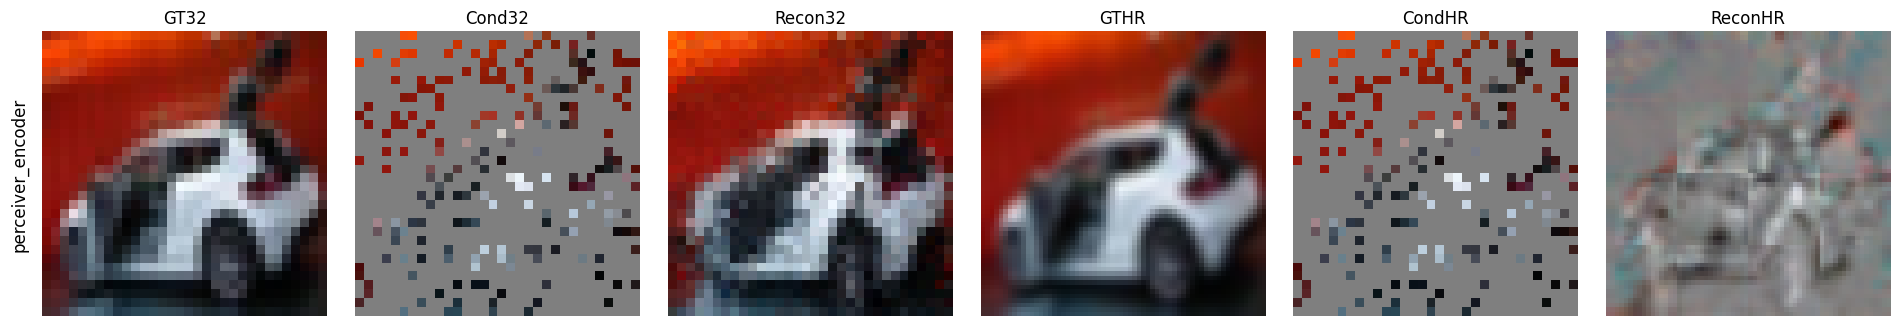

In [1]:
# === Sparse recon + decoder-only super-res (32x32 sampling, HR decode) ===
import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# 0) Repo root
if not (Path.cwd() / "src").exists():
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

torch._dynamo.config.disable = True

# 1) Imports
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# 2) Experiments
EXPERIMENTS = [
    dict(
        name="perceiver_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_perceiver/checkpoints/last-v1.ckpt",
        encoder_type="perceiver",
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        sparsity=0.4,
        cond_fraction=0.5,
    ),
]

# 3) Helpers
def build_lightning_model(cfg):
    main_scheduler = LinearScheduler()
    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=cfg["num_classes"])
    denoiser_kwargs = dict(
        in_channels=3,
        patch_size=cfg["patch_size"],
        num_groups=cfg["num_groups"],
        hidden_size=cfg["hidden_size"],
        decoder_hidden_size=cfg["decoder_hidden_size"],
        num_encoder_blocks=cfg["num_encoder_blocks"],
        num_decoder_blocks=cfg["num_decoder_blocks"],
        num_classes=cfg["num_classes"],
    )
    if "encoder_type" in cfg:
        denoiser_kwargs["encoder_type"] = cfg["encoder_type"]
    for k in ["max_points", "perceiver_num_latents", "perceiver_cross_heads"]:
        if k in cfg:
            denoiser_kwargs[k] = cfg[k]
    denoiser = PixNerDiT(**denoiser_kwargs)
    sampler = EulerSampler(
        num_steps=600,
        guidance=2.0,
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
    )
    trainer = FlowMatchingTrainer(scheduler=main_scheduler, lognorm_t=True, timeshift=1.0)
    ema_tracker = SimpleEMA(decay=0.9999)
    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=cfg["sparsity"],
        cond_fraction=cfg["cond_fraction"],
    )
    return model

def load_ckpt_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    model = model.to(device)
    model.eval()
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    return missing, unexpected

@torch.no_grad()
def run_sparse_recon_decoder_superres(model, images, labels, superres_scale=2):
    """
    Sampling and conditioning at 32x32.
    Super-res is produced by a single decoder-only pass with superres_scale>1.
    """
    device = images.device
    B = images.shape[0]

    # 32x32 recon (sampling)
    x_latent_32 = model.vae.encode(images)
    cond_mask_32, target_mask_32 = model._make_sparsity_masks(x_latent_32)
    condition, uncondition = model.conditioner(labels)

    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_32,
        condition,
        uncondition,
        cond_mask=cond_mask_32,
        x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    mse32_full = F.mse_loss(recon_32, images).item()
    inv_mask32 = (1.0 - cond_mask_32).expand_as(images)
    mse32_noncond = ((recon_32 - images) ** 2 * inv_mask32).sum() / (inv_mask32.sum() + 1e-8)
    mse32_noncond = mse32_noncond.item()
    cond_vis_32 = cond_mask_32.expand_as(images) * images

    # Decoder-only super-res: use t=0 so the network output approximates the data at HR
    t_zero = torch.zeros(B, device=device, dtype=samples_latent_32.dtype)
    recon_hr = model.ema_denoiser(
        samples_latent_32,
        t_zero,
        labels,
        cond_mask=cond_mask_32,        # still 32x32 mask; encoder stays base res
        superres_scale=superres_scale,  # decoder folds to HR
    )

    # For CIFAR, GT HR is just an upsample for reference
    H_hr = images.shape[-2] * superres_scale
    W_hr = images.shape[-1] * superres_scale
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)

    msehr_full = F.mse_loss(recon_hr, images_hr).item()
    msehr_noncond = ((recon_hr - images_hr) ** 2).mean().item()  # no HR mask; base-res mask only

    cond_vis_hr = F.interpolate(cond_vis_32, size=(H_hr, W_hr), mode="nearest")

    metrics = dict(
        mse32_full=mse32_full,
        mse32_noncond=mse32_noncond,
        msehr_full=msehr_full,
        msehr_noncond=msehr_noncond,
    )
    return recon_32, cond_vis_32, recon_hr, cond_vis_hr, images_hr, metrics

def to_img01(x):
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# 4) Load CIFAR-10 batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])
ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# 5) Run and plot
all_results = []
for cfg in EXPERIMENTS:
    print("\n" + "="*80)
    print(f"Experiment: {cfg['name']} | encoder_type={cfg.get('encoder_type','(default)')}")
    print(f"ckpt: {cfg['ckpt_path']}")

    model = build_lightning_model(cfg)
    missing, unexpected = load_ckpt_into_model(model, cfg["ckpt_path"], device=device)
    if len(missing) or len(unexpected):
        print(f"[load_state_dict strict=False] missing={len(missing)} unexpected={len(unexpected)}")

    recon32, cond32, reconHR, condHR, gtHR, metrics = run_sparse_recon_decoder_superres(
        model, images, labels, superres_scale=2
    )
    print("Metrics:", metrics)
    all_results.append((cfg["name"], metrics, recon32, cond32, reconHR, condHR, gtHR))

cols = ["GT32", "Cond32", "Recon32", "GTHR", "CondHR", "ReconHR"]
rows = len(all_results)
plt.figure(figsize=(3.2*len(cols), 3.2*rows))
for r, (name, metrics, recon32, cond32, reconHR, condHR, gtHR) in enumerate(all_results):
    gt32 = images
    for c, (title, tensor) in enumerate([
        ("GT32", gt32),
        ("Cond32", cond32),
        ("Recon32", recon32),
        ("GTHR", gtHR),
        ("CondHR", condHR),
        ("ReconHR", reconHR),
    ]):
        ax = plt.subplot(rows, len(cols), r*len(cols) + c + 1)
        ax.imshow(to_img01(tensor[6]).permute(1,2,0))
        ax.axis("off")
        if r == 0:
            ax.set_title(title)
        if c == 0:
            ax.text(-0.05, 0.5, name, transform=ax.transAxes, rotation=90,
                    va="center", ha="right", fontsize=12)
plt.tight_layout()
plt.show()


Files already downloaded and verified


current sampler is ODE sampler, but w_scheduler is enabled
/tmp/ipykernel_280534/427689275.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, 

Metrics: {'mse32_full': 0.03686714917421341, 'mse32_noncond': tensor(0.0461, device='cuda:0'), 'msehr_full': 0.23839613795280457}


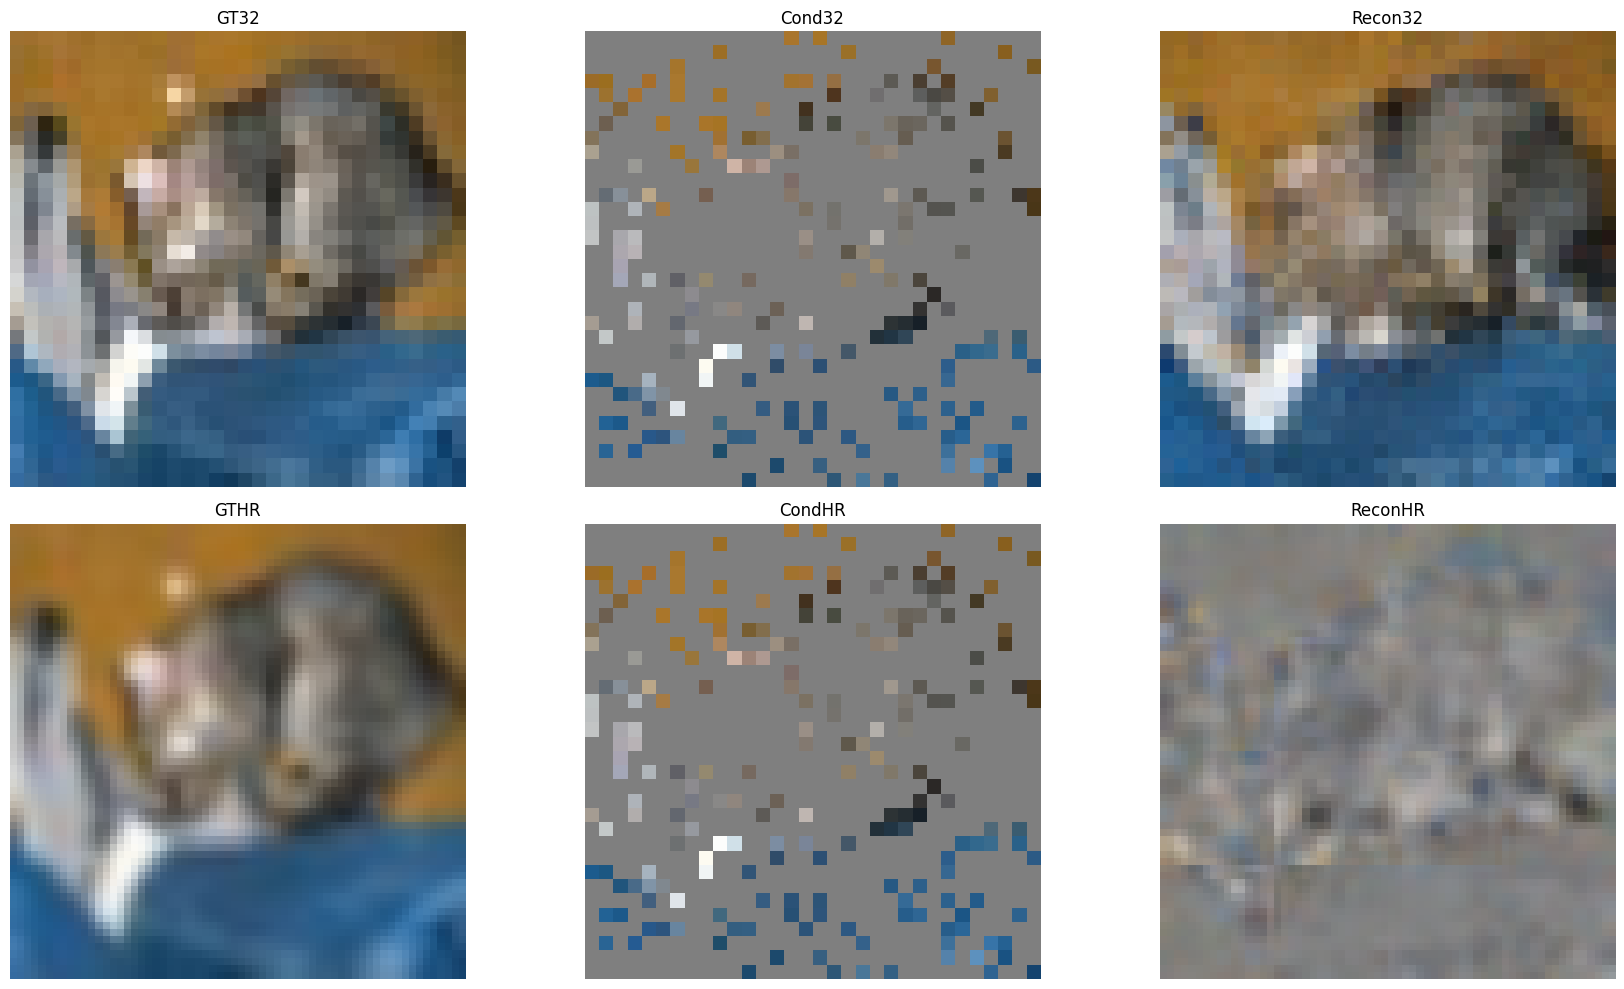

In [9]:
# %% 32x32 diffusion + decoder-only super-res (no HR masks)
import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Repo root
if not (Path.cwd() / "src").exists():
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

torch._dynamo.config.disable = True

# Imports
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# Config (Perceiver ckpt)
CKPT = "/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_perceiver/checkpoints/last-v1.ckpt"
SUPERRES_SCALE = 2  # change to 1, 1.5, 2, 4, etc.

def build_model():
    main_scheduler = LinearScheduler()
    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=10)
    denoiser = PixNerDiT(
        in_channels=3,
        patch_size=8,
        num_groups=8,
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        num_classes=10,
        encoder_type="perceiver",
    )
    sampler = EulerSampler(
        num_steps=600,
        guidance=2.0,
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
    )
    trainer = FlowMatchingTrainer(scheduler=main_scheduler, lognorm_t=True, timeshift=1.0)
    ema_tracker = SimpleEMA(decay=0.9999)
    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=0.4,
        cond_fraction=0.5,
    )
    return model

def load_ckpt(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    model = model.to(device)
    model.eval()
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    if missing or unexpected:
        print(f"[strict=False] missing={len(missing)} unexpected={len(unexpected)}")
    return model

@torch.no_grad()
def run(model, images, labels, superres_scale=2):
    device = images.device
    B = images.shape[0]

    # 32x32 diffusion (conditioning enforced only here)
    x_latent_32 = model.vae.encode(images)
    cond_mask_32, _ = model._make_sparsity_masks(x_latent_32)
    condition, uncondition = model.conditioner(labels)
    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_32,
        condition,
        uncondition,
        cond_mask=cond_mask_32,
        x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    # Decoder-only super-res: single forward at t=0 with bigger decoder patches
    t_zero = torch.zeros(B, device=device, dtype=samples_latent_32.dtype)
    recon_hr = model.ema_denoiser(
        samples_latent_32,
        t_zero,
        labels,
        cond_mask=cond_mask_32,          # still 32x32 mask; encoder stays base res
        superres_scale=superres_scale,   # decoder folds to HR
    )

    H_hr, W_hr = images.shape[-2] * superres_scale, images.shape[-1] * superres_scale
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)
    cond_vis_32 = cond_mask_32.expand_as(images) * images
    cond_vis_hr = F.interpolate(cond_vis_32, size=(H_hr, W_hr), mode="nearest")

    metrics = dict(
        mse32_full=F.mse_loss(recon_32, images).item(),
        mse32_noncond=(((recon_32 - images) ** 2) * (1 - cond_mask_32).expand_as(images)).sum().item()
                      / ((1 - cond_mask_32).sum() * images.shape[1] + 1e-8),
        msehr_full=F.mse_loss(recon_hr, images_hr).item(),
    )
    return recon_32, cond_vis_32, recon_hr, cond_vis_hr, images_hr, metrics

def to_img01(x):
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
tfm = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# Run
model = load_ckpt(build_model(), CKPT, device)
recon32, cond32, reconHR, condHR, gtHR, metrics = run(model, images, labels, superres_scale=SUPERRES_SCALE)
print("Metrics:", metrics)

# Plot first sample
cols = ["GT32", "Cond32", "Recon32", "GTHR", "CondHR", "ReconHR"]
tensors = [images, cond32, recon32, gtHR, condHR, reconHR]
plt.figure(figsize=(18, 10))
for i, (title, tensor) in enumerate(zip(cols, tensors)):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(to_img01(tensor[0]).permute(1,2,0))
    ax.set_title(title); ax.axis("off")
plt.tight_layout(); plt.show()


Files already downloaded and verified


current sampler is ODE sampler, but w_scheduler is enabled


Loading Perceiver ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_scent/checkpoints/last-v1.ckpt


/tmp/ipykernel_424246/3826197605.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Strict load -> missing: 0, unexpected: 0
steps= 50 | guidance=1.50 | scale=2 | lift=1 -> mse128_noncond=0.1344, clamp_max=0.0000e+00
steps= 50 | guidance=1.50 | scale=2 | lift=2 -> mse128_noncond=0.0265, clamp_max=0.0000e+00
steps= 50 | guidance=1.50 | scale=4 | lift=1 -> mse128_noncond=0.3224, clamp_max=0.0000e+00


current sampler is ODE sampler, but w_scheduler is enabled


steps= 50 | guidance=1.50 | scale=4 | lift=2 -> mse128_noncond=0.1335, clamp_max=0.0000e+00
steps= 50 | guidance=2.00 | scale=2 | lift=1 -> mse128_noncond=0.1392, clamp_max=0.0000e+00
steps= 50 | guidance=2.00 | scale=2 | lift=2 -> mse128_noncond=0.0231, clamp_max=0.0000e+00
steps= 50 | guidance=2.00 | scale=4 | lift=1 -> mse128_noncond=0.3121, clamp_max=0.0000e+00


current sampler is ODE sampler, but w_scheduler is enabled


steps= 50 | guidance=2.00 | scale=4 | lift=2 -> mse128_noncond=0.1361, clamp_max=0.0000e+00
steps=100 | guidance=1.50 | scale=2 | lift=1 -> mse128_noncond=0.1290, clamp_max=0.0000e+00
steps=100 | guidance=1.50 | scale=2 | lift=2 -> mse128_noncond=0.0257, clamp_max=0.0000e+00
steps=100 | guidance=1.50 | scale=4 | lift=1 -> mse128_noncond=0.3163, clamp_max=0.0000e+00


current sampler is ODE sampler, but w_scheduler is enabled


steps=100 | guidance=1.50 | scale=4 | lift=2 -> mse128_noncond=0.1410, clamp_max=0.0000e+00
steps=100 | guidance=2.00 | scale=2 | lift=1 -> mse128_noncond=0.1364, clamp_max=0.0000e+00
steps=100 | guidance=2.00 | scale=2 | lift=2 -> mse128_noncond=0.0251, clamp_max=0.0000e+00
steps=100 | guidance=2.00 | scale=4 | lift=1 -> mse128_noncond=0.2967, clamp_max=0.0000e+00


current sampler is ODE sampler, but w_scheduler is enabled


steps=100 | guidance=2.00 | scale=4 | lift=2 -> mse128_noncond=0.1416, clamp_max=0.0000e+00

Visualizing last run: scale=4, lift=2


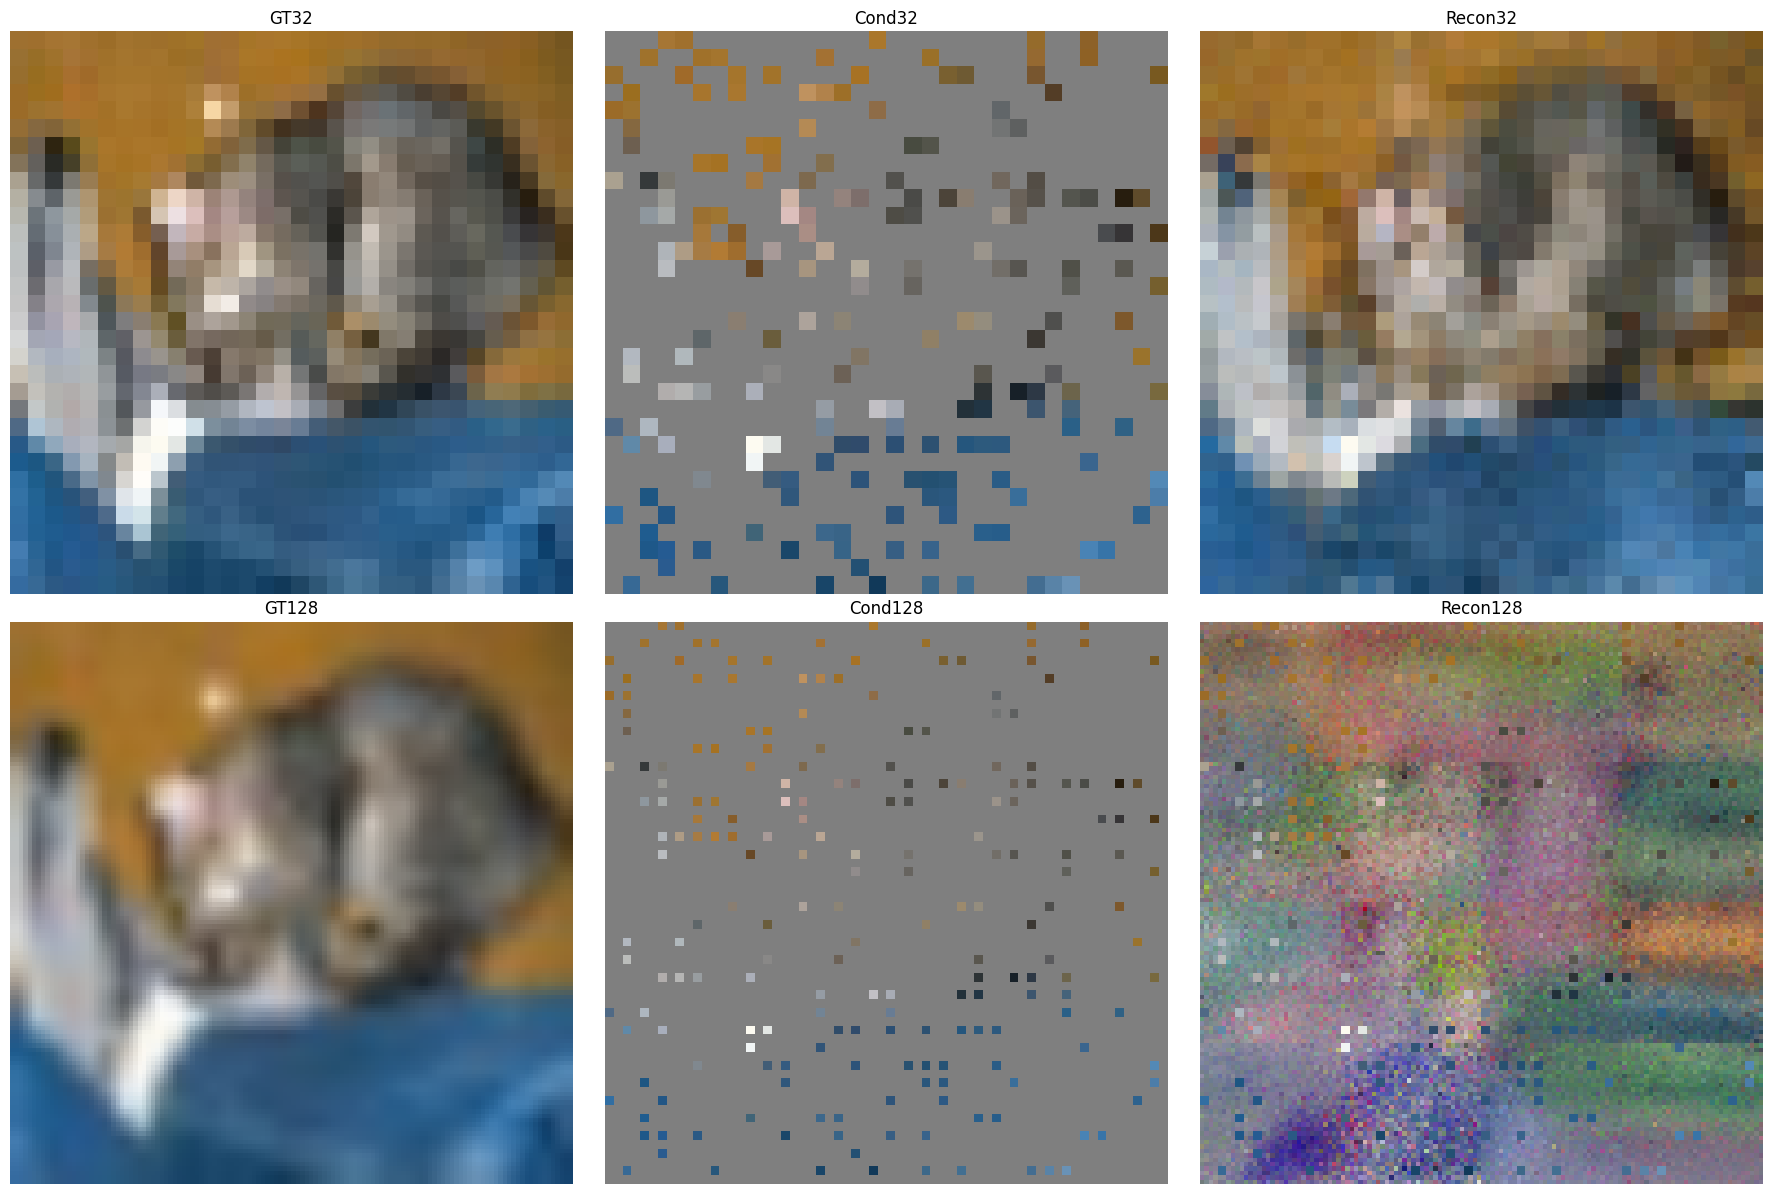

In [31]:
# %% Perceiver super-res diagnostics (fixed)

import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# -----------------------------------------------------------------------------
# 0) Repo root + torch settings
# -----------------------------------------------------------------------------
if not (Path.cwd() / "src").exists():
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

torch._dynamo.config.disable = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------------------------
# 1) Imports from project
# -----------------------------------------------------------------------------
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn, shift_respace_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# -----------------------------------------------------------------------------
# 2) Config — EDIT ckpt_path to your Perceiver checkpoint
# -----------------------------------------------------------------------------
cfg = dict(
    ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_scent/checkpoints/last-v1.ckpt",  # EDIT ME
    encoder_type="perceiver",
    hidden_size=512,
    decoder_hidden_size=64,
    num_encoder_blocks=8,
    num_decoder_blocks=2,
    patch_size=8,
    num_groups=8,
    num_classes=10,
    sparsity=0.4,
    cond_fraction=0.5,
    max_points=4096,
    perceiver_num_latents=256,
    perceiver_cross_heads=1,
    # inference knobs to sweep
    step_list=[50, 100],
    guidance_list=[1.5, 2.0],
    scales=[2, 4],
    lift_sizes=[1, 2],
)

# -----------------------------------------------------------------------------
# 3) Helpers
# -----------------------------------------------------------------------------
def make_sampler(num_steps, guidance, timeshift=1.0):
    main_scheduler = LinearScheduler()
    sam = EulerSampler(
        num_steps=num_steps,
        guidance=guidance,
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
        timeshift=timeshift,
    )
    return sam

def build_model(cfg, sampler):
    main_scheduler = sampler.scheduler  # same scheduler as sampler
    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=cfg["num_classes"])
    denoiser = PixNerDiT(
        in_channels=3,
        patch_size=cfg["patch_size"],
        num_groups=cfg["num_groups"],
        hidden_size=cfg["hidden_size"],
        decoder_hidden_size=cfg["decoder_hidden_size"],
        num_encoder_blocks=cfg["num_encoder_blocks"],
        num_decoder_blocks=cfg["num_decoder_blocks"],
        num_classes=cfg["num_classes"],
        encoder_type=cfg["encoder_type"],
        max_points=cfg["max_points"],
        perceiver_num_latents=cfg["perceiver_num_latents"],
        perceiver_cross_heads=cfg["perceiver_cross_heads"],
    )
    trainer = FlowMatchingTrainer(scheduler=main_scheduler, lognorm_t=True, timeshift=1.0)
    ema_tracker = SimpleEMA(decay=0.9999)
    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=cfg["sparsity"],
        cond_fraction=cfg["cond_fraction"],
    )
    return model

def load_ckpt(model, ckpt_path, device, strict=False):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=strict)
    model = model.to(device)
    model.eval()
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    return missing, unexpected

def lift_mask_and_cond(cond_mask_32, x_latent_32, scale, lift_size=1):
    B, _, H32, W32 = cond_mask_32.shape
    H_hr, W_hr = H32 * scale, W32 * scale
    cond_mask_128 = torch.zeros(B, 1, H_hr, W_hr, device=cond_mask_32.device, dtype=cond_mask_32.dtype)
    x_cond_128 = torch.zeros(B, x_latent_32.shape[1], H_hr, W_hr, device=x_latent_32.device, dtype=x_latent_32.dtype)
    for dy in range(lift_size):
        for dx in range(lift_size):
            cond_mask_128[:, :, dy::scale, dx::scale] = cond_mask_32
            x_cond_128[:, :, dy::scale, dx::scale] = x_latent_32
    x_cond_128 = x_cond_128 * cond_mask_128.expand_as(x_cond_128)
    return cond_mask_128, x_cond_128

@torch.no_grad()
def run_superres(model, images, labels, scale, lift_size):
    device = images.device
    x_latent_32 = model.vae.encode(images)
    cond_mask_32, target_mask_32 = model._make_sparsity_masks(x_latent_32)
    assert cond_mask_32.sum() > 0, "Empty conditioning mask!"
    condition, uncondition = model.conditioner(labels)

    # 32x32 recon
    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser, noise_32, condition, uncondition,
        cond_mask=cond_mask_32, x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    # HR prep
    H_hr = images.shape[-2] * scale
    W_hr = images.shape[-1] * scale
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)
    cond_mask_128, x_cond_128 = lift_mask_and_cond(cond_mask_32, x_latent_32, scale=scale, lift_size=lift_size)
    assert cond_mask_128.sum() == cond_mask_32.sum() * (lift_size ** 2), "Lifted mask count mismatch!"

    # adjust decoder scaling
    def set_scale(net, s):
        if hasattr(net, "decoder_patch_scaling_h"):
            net.decoder_patch_scaling_h = s
            net.decoder_patch_scaling_w = s
    old = (
        getattr(model.denoiser, "decoder_patch_scaling_h", 1.0),
        getattr(model.denoiser, "decoder_patch_scaling_w", 1.0),
        getattr(model.ema_denoiser, "decoder_patch_scaling_h", 1.0),
        getattr(model.ema_denoiser, "decoder_patch_scaling_w", 1.0),
    )
    set_scale(model.denoiser, scale); set_scale(model.ema_denoiser, scale)

    noise_128 = torch.randn_like(x_cond_128)
    samples_latent_128 = model.diffusion_sampler(
        model.ema_denoiser, noise_128, condition, uncondition,
        cond_mask=cond_mask_128, x_cond=x_cond_128,
    )
    recon_128 = model.vae.decode(samples_latent_128)

    # restore scales
    model.denoiser.decoder_patch_scaling_h = old[0]; model.denoiser.decoder_patch_scaling_w = old[1]
    model.ema_denoiser.decoder_patch_scaling_h = old[2]; model.ema_denoiser.decoder_patch_scaling_w = old[3]

    # metrics + clamping check
    mse32_full = F.mse_loss(recon_32, images).item()
    inv_mask32 = (1.0 - cond_mask_32).expand_as(images)
    mse32_noncond = ((recon_32 - images) ** 2 * inv_mask32).sum() / (inv_mask32.sum() + 1e-8)
    mse32_noncond = mse32_noncond.item()

    mse128_full = F.mse_loss(recon_128, images_hr).item()
    inv_mask128 = (1.0 - cond_mask_128).expand_as(images_hr)
    mse128_noncond = ((recon_128 - images_hr) ** 2 * inv_mask128).sum() / (inv_mask128.sum() + 1e-8)
    mse128_noncond = mse128_noncond.item()

    clamp_error = ((recon_128 - x_cond_128) * cond_mask_128.expand_as(recon_128)).abs().max().item()

    return dict(
        recon32=recon_32, recon128=recon_128, gt128=images_hr,
        cond32=cond_mask_32 * images, cond128=model.vae.decode(x_cond_128),
        metrics=dict(
            mse32_full=mse32_full, mse32_noncond=mse32_noncond,
            mse128_full=mse128_full, mse128_noncond=mse128_noncond,
            clamp_max=clamp_error,
        ),
    )

def to_img01(x):
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# -----------------------------------------------------------------------------
# 4) Load data (fixed batch)
# -----------------------------------------------------------------------------
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# -----------------------------------------------------------------------------
# 5) Run diagnostics
# -----------------------------------------------------------------------------
results = []
for steps in cfg["step_list"]:
    for guidance in cfg["guidance_list"]:
        sampler = make_sampler(num_steps=steps, guidance=guidance, timeshift=1.0)
        model = build_model(cfg, sampler)
        if steps == cfg["step_list"][0] and guidance == cfg["guidance_list"][0]:
            print(f"Loading Perceiver ckpt: {cfg['ckpt_path']}")
            missing_strict, unexpected_strict = load_ckpt(model, cfg["ckpt_path"], device, strict=True)
            print(f"Strict load -> missing: {len(missing_strict)}, unexpected: {len(unexpected_strict)}")
            if missing_strict or unexpected_strict:
                missing, unexpected = load_ckpt(model, cfg["ckpt_path"], device, strict=False)
                print(f"Relaxed load -> missing: {len(missing)}, unexpected: {len(unexpected)}")
        else:
            load_ckpt(model, cfg["ckpt_path"], device, strict=False)

        for scale in cfg["scales"]:
            for lift in cfg["lift_sizes"]:
                out = run_superres(model, images, labels, scale=scale, lift_size=lift)
                results.append((steps, guidance, scale, lift, out["metrics"]))
                print(f"steps={steps:3d} | guidance={guidance:.2f} | scale={scale} | lift={lift} -> "
                      f"mse128_noncond={out['metrics']['mse128_noncond']:.4f}, "
                      f"clamp_max={out['metrics']['clamp_max']:.4e}")

# -----------------------------------------------------------------------------
# 6) Quick visualization of the last run (change indices as needed)
# -----------------------------------------------------------------------------
if results:
    _, _, scale, lift, _ = results[-1]
    print(f"\nVisualizing last run: scale={scale}, lift={lift}")
    sampler = make_sampler(num_steps=results[-1][0], guidance=results[-1][1], timeshift=1.0)
    model = build_model(cfg, sampler)
    load_ckpt(model, cfg["ckpt_path"], device, strict=False)
    out = run_superres(model, images, labels, scale=scale, lift_size=lift)
    cols = ["GT32", "Cond32", "Recon32", "GT128", "Cond128", "Recon128"]
    tensors = [
        images, out["cond32"], out["recon32"],
        out["gt128"], out["cond128"], out["recon128"],
    ]
    plt.figure(figsize=(18, 12))
    for i, (title, tensor) in enumerate(zip(cols, tensors)):
        ax = plt.subplot(2, 3, i + 1)
        ax.imshow(to_img01(tensor[0]).permute(1, 2, 0))
        ax.set_title(title); ax.axis("off")
    plt.tight_layout()
    plt.show()


Files already downloaded and verified

Experiment: perceiver_encoder | encoder_type=perceiver
ckpt: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_scent/checkpoints/last-v1.ckpt


current sampler is ODE sampler, but w_scheduler is enabled
/tmp/ipykernel_424246/2225637811.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path

Metrics: {'mse32_full': 0.0358610600233078, 'mse32_noncond': 0.04483726993203163, 'mse128_full': 0.0387299619615078, 'mse128_noncond': 0.03910932317376137, 'cond_count_32': 1640.0, 'cond_count_128': 1640.0}


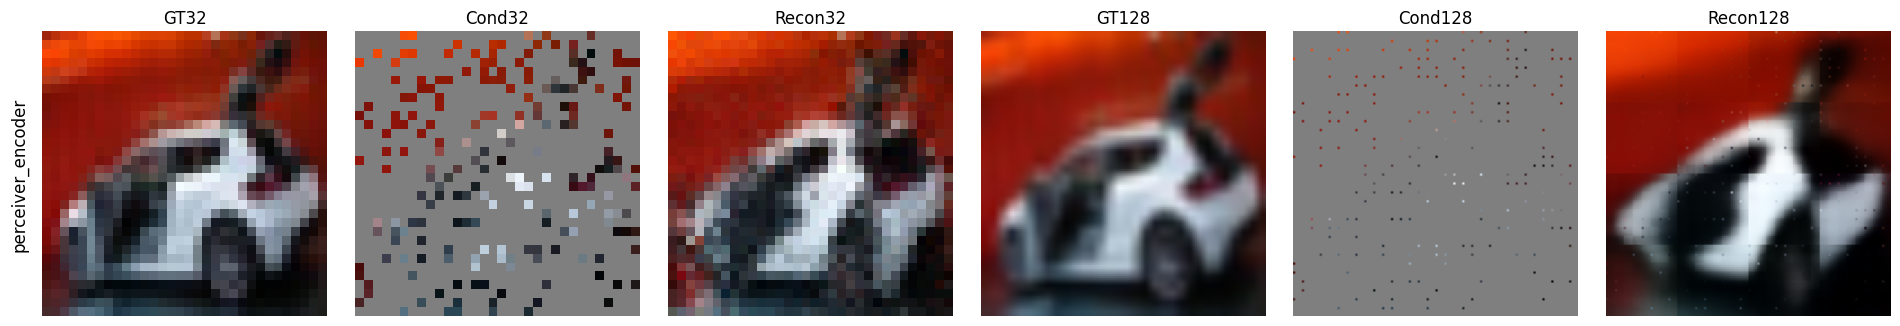

In [20]:
# === Sparse recon + super-res eval for PixNerDiT (grid vs perceiver encoders) ===
import os, sys
from pathlib import Path
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

# -----------------------
# 0) Make sure we're in the PixNerd repo root (so `import src...` works)
# -----------------------
if not (Path.cwd() / "src").exists():
    # common: notebook is in parent dir
    for cand in [Path.cwd() / "PixNerd", Path.cwd().parent / "PixNerd"]:
        if (cand / "src").exists():
            os.chdir(cand)
            sys.path.insert(0, str(cand))
            break

# Disable torch.compile/dynamo issues (matches your training script style)
torch._dynamo.config.disable = True

# -----------------------
# 1) Imports from your codebase
# -----------------------
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel

# -----------------------
# 2) Configure what to compare
#    - Use separate ckpts if you actually trained separate models.
#    - If you try to load a "grid" ckpt into a "perceiver" model, strict=False will skip mismatched weights.
# -----------------------
EXPERIMENTS = [
    # dict(
    #     name="grid_encoder",
    #     ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_grid/checkpoints/last.ckpt",
    #     encoder_type="grid",          # "grid" or "perceiver"
    #     # match training hyperparams:
    #     hidden_size=512,
    #     decoder_hidden_size=64,
    #     num_encoder_blocks=8,
    #     num_decoder_blocks=2,
    #     patch_size=8,
    #     num_groups=8,
    #     num_classes=10,
    #     # sparsity behavior:
    #     sparsity=0.4,
    #     cond_fraction=0.5,
    # ),
    dict(
        name="perceiver_encoder",
        ckpt_path="/pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_scent/checkpoints/last-v1.ckpt",
        encoder_type="perceiver",
        hidden_size=512,
        decoder_hidden_size=64,
        num_encoder_blocks=8,
        num_decoder_blocks=2,
        patch_size=8,
        num_groups=8,
        num_classes=10,
        sparsity=0.4,
        cond_fraction=0.5,
        # perceiver-specific knobs (only used if your PixNerDiT exposes them in __init__)
        # max_points=4096,
        # perceiver_num_latents=256,
        # perceiver_cross_heads=1,
    ),
]

# -----------------------
# 3) Helpers
# -----------------------
def build_lightning_model(cfg):
    main_scheduler = LinearScheduler()

    vae = PixelAE(scale=1.0)
    conditioner = LabelConditioner(num_classes=cfg["num_classes"])

    # Build denoiser
    denoiser_kwargs = dict(
        in_channels=3,
        patch_size=cfg["patch_size"],
        num_groups=cfg["num_groups"],
        hidden_size=cfg["hidden_size"],
        decoder_hidden_size=cfg["decoder_hidden_size"],
        num_encoder_blocks=cfg["num_encoder_blocks"],
        num_decoder_blocks=cfg["num_decoder_blocks"],
        num_classes=cfg["num_classes"],
    )
    # If your PixNerDiT has encoder_type in its signature, pass it:
    if "encoder_type" in cfg:
        denoiser_kwargs["encoder_type"] = cfg["encoder_type"]

    # Optional perceiver knobs if present in your model signature
    for k in ["max_points", "perceiver_num_latents", "perceiver_cross_heads"]:
        if k in cfg:
            denoiser_kwargs[k] = cfg[k]

    denoiser = PixNerDiT(**denoiser_kwargs)

    sampler = EulerSampler(
        num_steps=200,                 # you can change
        guidance=0.5,                 # you can change
        guidance_interval_min=0.0,
        guidance_interval_max=1.0,
        scheduler=main_scheduler,
        w_scheduler=LinearScheduler(),
        guidance_fn=simple_guidance_fn,
        step_fn=ode_step_fn,
    )

    trainer = FlowMatchingTrainer(
        scheduler=main_scheduler,
        lognorm_t=True,
        timeshift=1.0,
    )

    ema_tracker = SimpleEMA(decay=0.9999)

    model = LightningModel(
        vae=vae,
        conditioner=conditioner,
        denoiser=denoiser,
        diffusion_trainer=trainer,
        diffusion_sampler=sampler,
        ema_tracker=ema_tracker,
        optimizer=None,
        lr_scheduler=None,
        eval_original_model=False,
        sparsity=cfg["sparsity"],
        cond_fraction=cfg["cond_fraction"],
    )
    return model


def load_ckpt_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    model = model.to(device)
    model.eval()
    # keep inference stable
    model.ema_denoiser.to(torch.float32)
    model.denoiser.to(torch.float32)
    return missing, unexpected

@torch.no_grad()
@torch.no_grad()
def run_sparse_recon(model, images, labels, superres_scale=4, sigma_init=0.05, warm_start=True):
    """
    images: (B,3,32,32) in [-1,1]
    Returns:
      recon_32, cond_vis_32, recon_128, cond_vis_128, gt128, metrics
    """
    device = images.device
    B = images.shape[0]
    scale = superres_scale

    # -----------------------
    # 32x32 recon
    # -----------------------
    x_latent_32 = model.vae.encode(images)  # (B,C,32,32)
    cond_mask_32, target_mask_32 = model._make_sparsity_masks(x_latent_32)

    condition, uncondition = model.conditioner(labels)

    noise_32 = torch.randn_like(x_latent_32)
    samples_latent_32 = model.diffusion_sampler(
        model.ema_denoiser,
        noise_32,
        condition,
        uncondition,
        cond_mask=cond_mask_32,
        x_cond=x_latent_32,
    )
    recon_32 = model.vae.decode(samples_latent_32)

    mse32_full = F.mse_loss(recon_32, images).item()
    inv_mask32 = (1.0 - cond_mask_32).expand_as(images)
    mse32_noncond = ((recon_32 - images) ** 2 * inv_mask32).sum() / (inv_mask32.sum() + 1e-8)
    mse32_noncond = mse32_noncond.item()

    # visualize hints (grey elsewhere)
    cond_vis_32 = cond_mask_32.expand_as(images) * images

    # -----------------------
    # 128x128 super-res setup
    #   - GT128 is ONLY for eval/viz (upsampled GT)
    #   - conditioning is lifted from 32x32 (same # hints)
    # -----------------------
    H_hr = images.shape[-2] * scale
    W_hr = images.shape[-1] * scale
    images_hr = F.interpolate(images, size=(H_hr, W_hr), mode="bilinear", align_corners=False)

    # one-pixel lift mask: (B,1,128,128)
    cond_mask_128 = torch.zeros(B, 1, H_hr, W_hr, device=device, dtype=cond_mask_32.dtype)
    cond_mask_128[:, :, ::scale, ::scale] = cond_mask_32

    # one-pixel lift values: (B,C,128,128)
    x_cond_128 = torch.zeros(B, x_latent_32.shape[1], H_hr, W_hr, device=device, dtype=x_latent_32.dtype)
    x_cond_128[:, :, ::scale, ::scale] = x_latent_32

    # paranoia: ensure nothing outside mask
    x_cond_128 = x_cond_128 * cond_mask_128.expand_as(x_cond_128)

    # -----------------------
    # decoder scaling ON (so model decodes at 128 grid)
    # -----------------------
    old = (
        getattr(model.denoiser, "decoder_patch_scaling_h", 1.0),
        getattr(model.denoiser, "decoder_patch_scaling_w", 1.0),
        getattr(model.ema_denoiser, "decoder_patch_scaling_h", 1.0),
        getattr(model.ema_denoiser, "decoder_patch_scaling_w", 1.0),
    )
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h = scale
        model.denoiser.decoder_patch_scaling_w = scale
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h = scale
        model.ema_denoiser.decoder_patch_scaling_w = scale

    # -----------------------
    # 128x128 initialization
    # -----------------------
    if warm_start:
        # warm-start from the MODEL's 32x32 sample (not GT)
        init_128 = F.interpolate(samples_latent_32, scale_factor=scale, mode="nearest")
    else:
        init_128 = torch.randn_like(x_cond_128)

    if sigma_init > 0:
        init_128 = init_128 + sigma_init * torch.randn_like(init_128)

    # IMPORTANT: clamp conditioning BEFORE entering sampler
    init_128 = cond_mask_128.expand_as(init_128) * x_cond_128 + (1.0 - cond_mask_128.expand_as(init_128)) * init_128

    # -----------------------
    # sample 128
    # -----------------------
    samples_latent_128 = model.diffusion_sampler(
        model.ema_denoiser,
        init_128,
        condition,
        uncondition,
        cond_mask=cond_mask_128,
        x_cond=x_cond_128,
    )
    recon_128 = model.vae.decode(samples_latent_128)

    # restore scaling
    if hasattr(model.denoiser, "decoder_patch_scaling_h"):
        model.denoiser.decoder_patch_scaling_h, model.denoiser.decoder_patch_scaling_w = old[0], old[1]
    if hasattr(model.ema_denoiser, "decoder_patch_scaling_h"):
        model.ema_denoiser.decoder_patch_scaling_h, model.ema_denoiser.decoder_patch_scaling_w = old[2], old[3]

    mse128_full = F.mse_loss(recon_128, images_hr).item()
    inv_mask128 = (1.0 - cond_mask_128).expand_as(images_hr)
    mse128_noncond = ((recon_128 - images_hr) ** 2 * inv_mask128).sum() / (inv_mask128.sum() + 1e-8)
    mse128_noncond = mse128_noncond.item()

    # visualize what you *actually* condition on (in image space)
    cond_vis_128 = cond_mask_128.expand_as(images_hr) * images_hr

    metrics = dict(
        mse32_full=mse32_full,
        mse32_noncond=mse32_noncond,
        mse128_full=mse128_full,
        mse128_noncond=mse128_noncond,
        cond_count_32=float(cond_mask_32.sum().item()),
        cond_count_128=float(cond_mask_128.sum().item()),
    )
    return recon_32, cond_vis_32, recon_128, cond_vis_128, images_hr, metrics




def to_img01(x):
    # x: [-1,1] -> [0,1]
    return ((x.clamp(-1, 1) + 1) / 2).detach().cpu()

# -----------------------
# 4) Load a fixed CIFAR-10 batch
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # -> [-1,1]
])

ds = CIFAR10(root="./data", train=False, download=True, transform=tfm)
BATCH = 8
images = torch.stack([ds[i][0] for i in range(BATCH)], dim=0).to(device)
labels = torch.tensor([ds[i][1] for i in range(BATCH)], dtype=torch.long).to(device)

# -----------------------
# 5) Run each experiment and plot
# -----------------------
all_results = []

for cfg in EXPERIMENTS:
    print("\n" + "="*80)
    print(f"Experiment: {cfg['name']} | encoder_type={cfg.get('encoder_type','(default)')}")
    print(f"ckpt: {cfg['ckpt_path']}")

    model = build_lightning_model(cfg)
    missing, unexpected = load_ckpt_into_model(model, cfg["ckpt_path"], device=device)

    if len(missing) or len(unexpected):
        print(f"[load_state_dict strict=False] missing={len(missing)} unexpected={len(unexpected)}")
        # uncomment if you want details:
        # print("missing:", missing[:20])
        # print("unexpected:", unexpected[:20])

    recon32, cond32, recon128, cond128, gt128, metrics = run_sparse_recon(
        model, images, labels, superres_scale=4
    )

    print("Metrics:", metrics)

    all_results.append((cfg["name"], metrics, recon32, cond32, recon128, cond128, gt128))

# Plot: rows = experiments, cols = GT32 | Cond32 | Recon32 | GT128 | Cond128 | Recon128
cols = ["GT32", "Cond32", "Recon32", "GT128", "Cond128", "Recon128"]
rows = len(all_results)
plt.figure(figsize=(3.2*len(cols), 3.2*rows))

for r, (name, metrics, recon32, cond32, recon128, cond128, gt128) in enumerate(all_results):
    gt32 = images
    for c, (title, tensor) in enumerate([
        ("GT32", gt32),
        ("Cond32", cond32),
        ("Recon32", recon32),
        ("GT128", gt128),
        ("Cond128", cond128),
        ("Recon128", recon128),
    ]):
        ax = plt.subplot(rows, len(cols), r*len(cols) + c + 1)
        # show first image of the batch
        ax.imshow(to_img01(tensor[6]).permute(1,2,0))
        ax.axis("off")
        if r == 0:
            ax.set_title(title)
        if c == 0:
            ax.text(-0.05, 0.5, name, transform=ax.transAxes, rotation=90,
                    va="center", ha="right", fontsize=12)

plt.tight_layout()
plt.show()
